Import all required python modules.

In [1]:
import cf_units
import cftime

In [2]:
import stratify

In [3]:
import iris
import numpy as np

In [4]:
from pathlib import Path

In [5]:
import matplotlib.pyplot as plt

In [6]:
import iris.quickplot as qplt

In [7]:
iris.FUTURE.date_microseconds = True

Load the grid mask data to use to regrid the ozone data.

In [8]:
esm_grid_mask_filepath = Path('/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/grids/global.N96/2020.05.19/qrparm.mask')

In [9]:
grid_cube = iris.load_cube(esm_grid_mask_filepath)
grid_cube.coord("latitude").guess_bounds()
grid_cube.coord("longitude").guess_bounds()

In [10]:
lat_points = grid_cube.coord("latitude").points
lon_points = grid_cube.coord("longitude").points

In [11]:
grid_coords = [("latitude", lat_points), ("longitude", lon_points)]

Load the ozone forcing data.

In [12]:
cmip6_pi_ozone_filepath = Path('/g/data/qv56/replicas/input4MIPs/CMIP6/CMIP/UReading/UReading-CCMI-1-0/atmos/monC/vmro3/gn/v20160830/vmro3_input4MIPs_ozone_CMIP_UReading-CCMI-1-0_gn_185001-185012.nc')

In [13]:
orig_ozone_cube = iris.load_cube(cmip6_pi_ozone_filepath)

Fix the time units. "months since" makes sense for calendar="360_day".

In [14]:
months_since_1850_units = cf_units.Unit('months since 1850-01-01 00:00', calendar='360_day')

In [15]:
time_coord_dim = orig_ozone_cube.coord_dims('time')

In [16]:
new_time_coord = iris.coords.DimCoord(
    orig_ozone_cube.coord('time').points,
    standard_name='time',
    units=months_since_1850_units
)

In [17]:
orig_ozone_cube.remove_coord('time')
orig_ozone_cube.add_dim_coord(new_time_coord, time_coord_dim)

Interpolate the original ozone cube to the grid coordinates used by ESM1.6.

In [18]:
grid_ozone_cube = orig_ozone_cube.interpolate(grid_coords, iris.analysis.Linear())

Select one month of data: December 1850, to match the one month of available pressure data.

In [19]:
nov = cftime.Datetime360Day(1850, 11, 30)

In [20]:
dec = iris.Constraint(time=lambda cell: cell.point > nov)

In [21]:
ozone_cube = grid_ozone_cube.extract(dec)

Change the pressure units from hPa to Pa to match the available pressure data.

In [22]:
ozone_cube.coord('air_pressure').convert_units('Pa')

Obtain the pressure data from a spinup file for December 2091.

In [23]:
spinup_filepath = Path('/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/June2025/output999/atmosphere/netCDF/aiihca.pa-209112_mon.nc')

In [24]:
spinup_cube = iris.load(spinup_filepath)

In [25]:
pressure_index = 94

In [26]:
pressure_cube = spinup_cube[pressure_index]

Compress the time axis because only one month's data is being used.

In [27]:
pressure_cube = pressure_cube.collapsed('time', iris.analysis.MEAN)

Plot the air pressure coordinate to see if it makes sense.

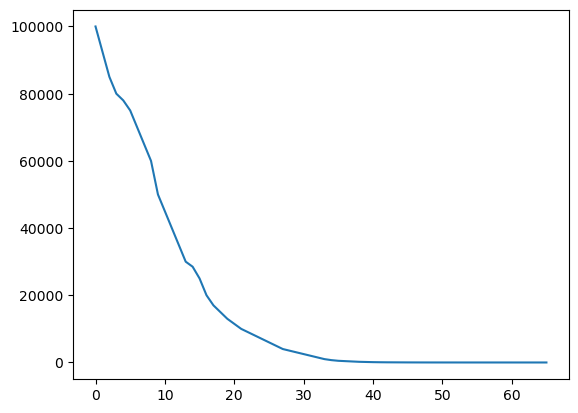

In [28]:
plt.plot(ozone_cube.coord('air_pressure').points)
plt.show()

The ozone forcing uses 66 pressure levels. The pressure data has pressure on 38 model levels. Interpolate the ozone pressure levels to obtain 38 pressure levels instead.

In [29]:
ozone_pressure_levels = ozone_cube.coord('air_pressure')

In [30]:
pressure_level_points = ozone_pressure_levels.points

In [31]:
nbr_pressure_levels = ozone_pressure_levels.shape[0]

In [32]:
model_levels = pressure_cube.coord('model_level_number')

In [33]:
model_level_points = model_levels.points

In [34]:
nbr_model_levels = model_levels.shape[0]

In [35]:
pressure_level_nbrs = range(1,nbr_pressure_levels+1)
new_pressure_level_nbrs = np.linspace(1,nbr_pressure_levels,nbr_model_levels)
new_pressure_level_points = np.interp(new_pressure_level_nbrs, pressure_level_nbrs, pressure_level_points)

Plot the pressure data to see if it makes sense.

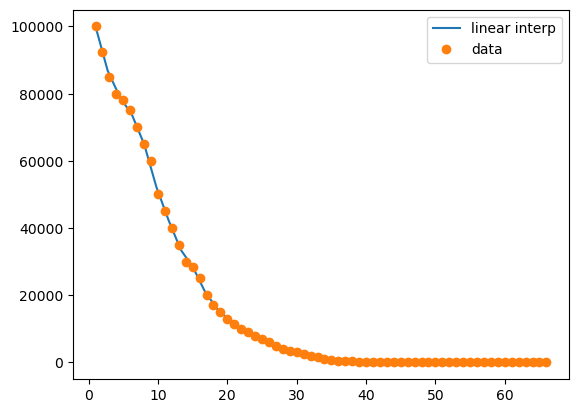

In [36]:
plt.plot(new_pressure_level_nbrs, new_pressure_level_points, '-', label='linear interp')
plt.plot(pressure_level_nbrs, pressure_level_points, 'o', label='data')
plt.legend(loc='best')
plt.show()

Do the pressure level interpolation.

In [37]:
interp = [('air_pressure', new_pressure_level_points)]
interp_ozone_cube = ozone_cube.interpolate(interp, iris.analysis.Linear())

Plot the ozone data at the new pressure levels to see if it makes sense.

0 100000.0 Pa


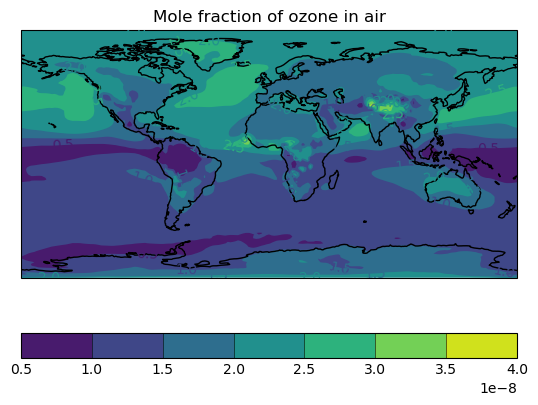

In [38]:
cube_at_level = lambda n: interp_ozone_cube[n,:,:]
pressure = interp_ozone_cube.coord('air_pressure')
for n in range(1):
    print(n, pressure.points[n], pressure.units)
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(n))
    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)
    plt.show()

Try to use `relevel` to interpolate from pressure levels to model levels. The little amount of documentation on how to do this is confusing!

In [39]:
from iris.experimental.stratify import relevel

In [40]:
tgt_levels = pressure_cube.coord('atmosphere_hybrid_height_coordinate').points.data
ozone_cube_levels = relevel(interp_ozone_cube, pressure_cube, tgt_levels)

Before interpolation, the 'air_pressure' coordinate is decreasing.

In [41]:
interp_ozone_cube.coord('air_pressure').points

array([1.00000000e+05, 8.68243243e+04, 7.89729730e+04, 7.36486486e+04,
       6.48648649e+04, 5.21621622e+04, 4.22972973e+04, 3.35135135e+04,
       2.83108108e+04, 2.09459459e+04, 1.58648649e+04, 1.25135135e+04,
       9.91891892e+03, 8.16216216e+03, 6.40540541e+03, 4.64864865e+03,
       3.44594595e+03, 2.56756757e+03, 1.68918919e+03, 8.86486486e+02,
       4.86486486e+02, 3.10810811e+02, 1.67567568e+02, 8.78378378e+01,
       4.83783784e+01, 3.08108126e+01, 1.66216223e+01, 8.70270270e+00,
       4.81081081e+00, 3.05405405e+00, 1.64864865e+00, 8.62162184e-01,
       4.78378380e-01, 3.02702714e-01, 1.63513519e-01, 9.02702702e-02,
       4.51351360e-02, 9.99999978e-03])

After interpolation, the 'air_pressure' coordinate is increasing and is actually 'atmosphere_hybrid_height_coordinate'.

In [42]:
ozone_cube_levels.coord('air_pressure').points

array([9.99820611e+00, 4.99988815e+01, 1.30000232e+02, 2.49998333e+02,
       4.10001035e+02, 6.10000486e+02, 8.50000613e+02, 1.13000142e+03,
       1.44999897e+03, 1.81000112e+03, 2.21000002e+03, 2.64999960e+03,
       3.12999986e+03, 3.65000079e+03, 4.20999847e+03, 4.81000075e+03,
       5.44999978e+03, 6.12999948e+03, 6.84999986e+03, 7.61000092e+03,
       8.40999873e+03, 9.25000113e+03, 1.01300003e+04, 1.10500001e+04,
       1.20100006e+04, 1.30100018e+04, 1.40504001e+04, 1.51377198e+04,
       1.62849737e+04, 1.75069688e+04, 1.88208202e+04, 2.02465990e+04,
       2.18081366e+04, 2.35421836e+04, 2.55209609e+04, 2.79013583e+04,
       3.10638886e+04, 3.60817633e+04])

pressure_cube.coord('atmosphere_hybrid_height_coordinate').points

0 9.9982061118072 Pa


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN slice encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


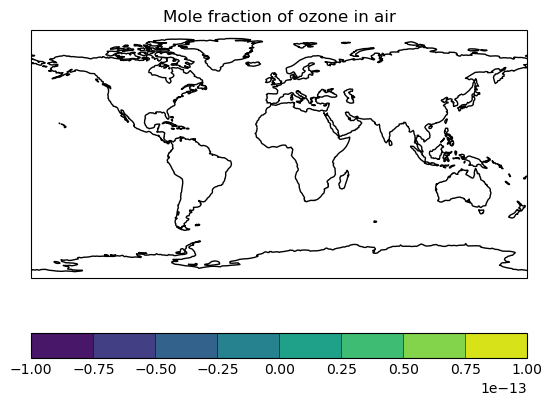

In [43]:
cube_at_level = lambda n: ozone_cube_levels[n,:,:]
pressure = ozone_cube_levels.coord('air_pressure')
for n in range(1):
    print(n, pressure.points[n], pressure.units)
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(n))
    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)
    plt.show()

The interpolation has resulted in all NaN values, probably as a result of [python-stratify issue #50](https://github.com/SciTools/python-stratify/issues/50) 

Try flipping the interpolation, just to see if NaN values are avoided.

In [44]:
tgt_levels = np.flip(pressure_cube.coord('atmosphere_hybrid_height_coordinate').points.data)
flipped_ozone_cube_levels = relevel(interp_ozone_cube, pressure_cube, tgt_levels)

0 9.9982061118072 Pa


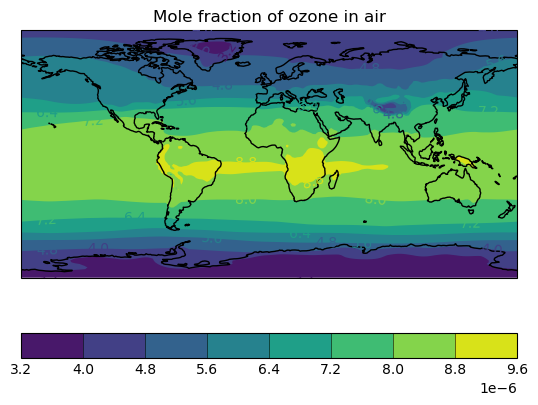

In [45]:
cube_at_level = lambda n: flipped_ozone_cube_levels[n,:,:]
pressure = ozone_cube_levels.coord('air_pressure')
for n in range(1):
    print(n, pressure.points[n], pressure.units)
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(n))
    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)
    plt.show()

The result is nonsense, but at least it does not contain NaN values.

Using 'model_level_number' instead of 'atmosphere_hybrid_height_coordinate' also yields NaN values, even when flipped.

In [46]:
pressure_cube.coord('model_level_number').points

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38], dtype=int32)

In [47]:
tgt_levels = np.flip(pressure_cube.coord('model_level_number').points)
model_ozone_cube_levels = relevel(interp_ozone_cube, pressure_cube, tgt_levels)

0 9.9982061118072 Pa


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN slice encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


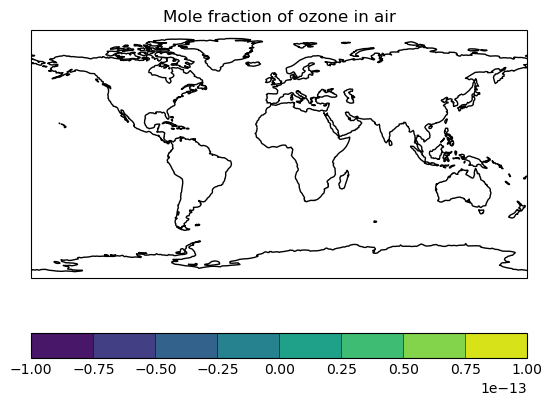

In [48]:
cube_at_level = lambda n: model_ozone_cube_levels[n,:,:]
pressure = ozone_cube_levels.coord('air_pressure')
for n in range(1):
    print(n, pressure.points[n], pressure.units)
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(n))
    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)
    plt.show()

In [49]:
pressure_cube

Air Pressure (Pa),model_level_number,latitude,longitude
Shape,38,145,192
Dimension coordinates,,,
model_level_number,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
atmosphere_hybrid_height_coordinate,x,-,-
sigma,x,-,-
surface_altitude,-,x,x
Derived coordinates,,,


In [50]:
interp_ozone_cube

<iris 'Cube' of mole_fraction_of_ozone_in_air / (mole mole-1) (air_pressure: 38; latitude: 145; longitude: 192)>